# Kaggle Competition: Ames Housing Dataset 
# Notebook 2: Danielle Reycer

## Scaling And Modeling

- [Imports and Reading in DataSets](#Imports-and-Reading-in-DataSets) <br>
- [Cleaning to Use Only Numeric Data](#Cleaning-to-Use-Only-Numeric-Data) <br>
- [Setting Up Data for Modeling](#Setting-Up-Data-for-Modeling)
- [Creating Baseline Model](#Creating-Baseline-Model)
- [Linear Regression on Numerical Columns](#Linear-Regression-on-Numerical-Columns) <br>
- [LassoCV on Numeric Columns](#LassoCV-on-Numeric-Columns)
- [RidgeCV on Numeric Columns](#RidgeCV-on-Numeric-Columns)

### Imports and Reading in DataSets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean, stdev

from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (cross_val_score, 
                                     train_test_split, 
                                     cross_validate, 
                                     KFold)

In [2]:
train = pd.read_csv('../datasets/train_clean1.csv')
test = pd.read_csv('../datasets/test_clean1.csv')

In [3]:
train.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice,all_baths,huge_lot,recession,neighborhood_scl
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,NaN,0,3,2010,WD,130500,3.0,0,0,1.371819
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,NaN,0,4,2009,WD,220000,4.0,0,0,1.877602
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,NaN,0,1,2010,WD,109000,2.0,0,0,1.459058
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,NaN,0,4,2010,WD,174000,3.0,0,0,2.410514
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,NaN,0,3,2010,WD,138500,2.0,0,0,1.877602


### Cleaning to Use Only Numeric Data

In order to be able to run models - before worrying too much about columns that may need to be dummied and other categorical columns, I decided to run my regression models on all the numeric data first. I created a copy of the dataframe and worked with that in order to move forward with these models, understanding that any cleaning I do here will not transfer over to the original dataframe.

In [4]:
numeric_train = train.select_dtypes(include = np.number).copy()
numeric_test = test.select_dtypes(include = np.number).copy()

Determining which columns have null values and how many.

In [5]:
numeric_train.isnull().sum().sort_values(ascending=False).head(5)

lot_frontage      330
garage_yr_blt     113
mas_vnr_area       22
all_baths           1
bsmt_half_bath      1
dtype: int64

In [6]:
numeric_test.isnull().sum().sort_values(ascending=False).head(5)

lot_frontage     160
garage_yr_blt     45
mas_vnr_area       1
id                 0
3ssn_porch         0
dtype: int64

I attempted to impute `'lot_frontage'` using `KNNImputer`, but it did not improve my model, so I commented it out here. 

In [7]:
# look at homes with blank lot_frontage to see if I can impute with 
# something better than the mean - trying KNNImputer
# https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e

# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=5)

# numeric_train_imputed = pd.DataFrame(imputer.fit_transform(numeric_train),columns = numeric_train.columns)
# numeric_test_imputed = pd.DataFrame(imputer.fit_transform(numeric_test), columns = numeric_test.columns)


I decided to impute the two nulls with the mean for those columns, since imputing one null value would introduce less bias that imputing a mean on several null values in a single column. 

In [8]:
numeric_train['bsmt_half_bath'].fillna((numeric_train['bsmt_half_bath'].mean()), inplace=True)
numeric_train['bsmt_full_bath'].fillna((numeric_train['bsmt_full_bath'].mean()), inplace=True)


In [9]:
# verifying that the null values were indeed imputed.
numeric_train.isnull().sum().sort_values(ascending=False).head(5)

lot_frontage     330
garage_yr_blt    113
mas_vnr_area      22
all_baths          1
id                 0
dtype: int64

Since the columns of `lot_frontage` and `garage_yr_blt` contained many more nulls, it felt better to not consider those columns as helpful in my model. Therefore, I drop them here.

In [10]:
numeric_train.dropna(axis=1, inplace=True) 

In [11]:
numeric_test.isnull().sum().sort_values(ascending=False).head(5)

lot_frontage     160
garage_yr_blt     45
mas_vnr_area       1
id                 0
3ssn_porch         0
dtype: int64

In [12]:
numeric_test.dropna(axis=1, inplace=True)

In [13]:
# verifying that the null columns were dropped.
numeric_test.isnull().sum().sort_values(ascending=False).head(5)

id               0
pid              0
kitchen_abvgr    0
totrms_abvgrd    0
fireplaces       0
dtype: int64

### Setting Up Data for Modeling

Creating features matrix, target vector, and `train_test_split` on the data to use in MLR, LassoCV and RidgeCV.

In [31]:
# basic linear regression on all the numeric columns
target = 'saleprice'
features = [column for column in numeric_train.columns if column != target]

X = numeric_train[features]
y = numeric_train[target]


#train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  random_state = 42)

# function to determine rmse based on my model
def find_rmse(model):
    y_true = y_val
    if model == LinearRegression:
        y_pred = lr.predict(X_val)
    elif model == LassoCV:
        y_pred = lasso_cv.predict(X_val_sc)
    elif model == RidgeCV:
        y_pred = ridge_cv.predict(X_val_sc)
    else:
        return "Cannot compute"
    return np.sqrt(mean_squared_error(y_true, y_pred))

X.shape

(2049, 39)

### Creating Baseline Model

In [33]:
train['baseline'] = train['saleprice'].mean()
y_baseline = train['baseline']
y_baseline[0], np.sqrt(mean_squared_error(train['saleprice'], y_baseline))

(181534.626159102, 79242.76900782275)

Our baseline model is the mean value of the sale price for our training data. This gives us a null model on which to improve. The rmse for my baseline was much higher than any of my initial models in notebook 1. 

The average distance between the predicted values and the actual values for sale price in the baseline model are about $79,242. 

As can be seen in the residual plot below, the residuals are right skewed just like the original sale price data. 

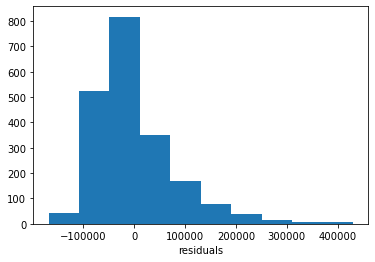

In [37]:
residuals = train['saleprice'] - train['baseline']
plt.hist(residuals)
plt.xlabel('residuals');

# we expect this to have the exact same shape as the histogram 
# of sale price, since this is simply a transformation of that graph

### Linear Regression on Numerical Columns

In [16]:
lr = LinearRegression(n_jobs= -1)
lr.fit(X_train, y_train)

scores = cross_val_score(lr, X_val, y_val)
lr.score(X_val, y_val), scores.mean()

(0.8688965297218958, 0.8502801614870175)

My model here isn't as overfit as the previous iterations in Notebook 1

In [17]:
# determining rmse
find_rmse(LinearRegression)

28047.990519281153

The average distance between the predicted values and the actual values for sale price in this linear regression model are about $28,048.

Best model of Notebook 1 and Notebook 2

In [27]:
cv_results = cross_validate(lr, X, y, cv=KFold(shuffle=True, 
                                               random_state=13), 
                            scoring=['neg_root_mean_squared_error', 'r2'], 
                            n_jobs=-1, return_train_score=True, 
                            return_estimator=True)

results = pd.DataFrame(cv_results)
results.rename({'test_neg_root_mean_squared_error': 'test_rmse', 
                'train_neg_root_mean_squared_error': 'train_rmse'}, 
                axis=1, inplace=True)
results[['train_r2', 'test_r2', 
         'train_rmse', 'test_rmse']]


,train_r2,test_r2,train_rmse,test_rmse
0,0.876333,0.720579,-27985.748812,-41045.695518
1,0.848196,0.876342,-30479.164657,-29246.171224
2,0.859835,0.793410,-29930.882893,-34665.173575
3,0.855588,0.850632,-29752.231964,-32042.030271
4,0.853366,0.857025,-30682.762573,-28581.023649


In [18]:
# export model to upload to Kaggle
X_test = numeric_test[features]

numeric_test['SalePrice'] = lr.predict(X_test)

test_export = numeric_test[['id', 'SalePrice']].copy()

test_export.rename(columns={'id':'Id'}, inplace=True)

test_export.to_csv('../attempts/attempt_13.csv', index = False)

### LassoCV on Numeric Columns

In [19]:
# instantiate and fit standard scaler
ss = StandardScaler()
ss.fit(X_train)

# save the standardized values
X_train_sc = ss.transform(X_train)
X_val_sc = ss.transform(X_val)

# transform test data as well for exported file
X_test_sc = ss.transform(numeric_test[features])

In [20]:
# fit Lasso
lasso_cv = LassoCV(cv=10)
lasso_cv.fit(X_train_sc, y_train)

lasso_cv.score(X_val_sc, y_val)

0.8652793555843994

In [21]:
find_rmse(LassoCV)

28432.283048577836

The average distance between the predicted values and the actual values for sale price in the Lasso model are about $28,432.

In [29]:
cv_results = cross_validate(lasso_cv, X_train_sc, y_train, cv=KFold(shuffle=True, 
                                               random_state=13), 
                            scoring=['neg_root_mean_squared_error', 'r2'], 
                            n_jobs=-1, return_train_score=True, 
                            return_estimator=True)

results = pd.DataFrame(cv_results)
results.rename({'test_neg_root_mean_squared_error': 'test_rmse', 
                'train_neg_root_mean_squared_error': 'train_rmse'}, 
                axis=1, inplace=True)
results[['train_r2', 'test_r2', 
         'train_rmse', 'test_rmse']]


,train_r2,test_r2,train_rmse,test_rmse
0,0.842106,0.855612,-31886.375618,-29381.577885
1,0.865374,0.723698,-29244.602687,-41786.542663
2,0.843051,0.851791,-32127.147917,-28344.772046
3,0.846274,0.828580,-30666.067422,-35299.930145
4,0.846652,0.819600,-30962.049749,-34768.637568


In [22]:
# viewed these as a starting place for my next notebook
# commented out to save scrolling
# [(feature, coef) for (feature, coef) in zip(X.columns, lasso_cv.coef_)]

In [23]:
numeric_test['SalePrice'] = lasso_cv.predict(X_test_sc)

test_export = numeric_test[['id', 'SalePrice']].copy()

test_export.rename(columns={'id':'Id'}, inplace=True)

test_export.to_csv('../attempts/attempt_14.csv', index = False)

### RidgeCV on Numeric Columns

In [38]:
ridge_cv = RidgeCV()
ridge_cv.fit(X_train_sc, y_train)

ridge_cv.score(X_val_sc, y_val), ridge_cv.score(X_train_sc, y_train)

(0.8689672711722414, 0.8511834735393304)

In [25]:
find_rmse(RidgeCV)

28040.422362421086

The average distance between the predicted values and the actual values for sale price in the Ridge model are about $28,040.

In [30]:
cv_results = cross_validate(ridge_cv, X_train_sc, y_train, cv=KFold(shuffle=True, 
                                               random_state=13), 
                            scoring=['neg_root_mean_squared_error', 'r2'], 
                            n_jobs=-1, return_train_score=True, 
                            return_estimator=True)

results = pd.DataFrame(cv_results)
results.rename({'test_neg_root_mean_squared_error': 'test_rmse', 
                'train_neg_root_mean_squared_error': 'train_rmse'}, 
                axis=1, inplace=True)
results[['train_r2', 'test_r2', 
         'train_rmse', 'test_rmse']]


,train_r2,test_r2,train_rmse,test_rmse
0,0.851432,0.840090,-30930.319996,-30920.605384
1,0.873127,0.688433,-28390.087976,-44373.164586
2,0.848376,0.856671,-31577.367348,-27874.219931
3,0.851890,0.839035,-30100.698198,-34206.492161
4,0.852779,0.797388,-30337.234060,-36846.926877


In [26]:
numeric_test['SalePrice'] = ridge_cv.predict(X_test_sc)

test_export = numeric_test[['id', 'SalePrice']].copy()

test_export.rename(columns={'id':'Id'}, inplace=True)

test_export.to_csv('../attempts/attempt_15.csv', index = False)

I decided not to export the 'numeric_train' and 'numeric_test' data set, because when I do more exploration, it will be with non numerical features. 